In [587]:
import numpy as np
import torch
from torch.autograd import Variable as V
import time
import torch.utils.data as Data
from torch import nn
from torch.nn import Module
from torch.nn import TransformerEncoderLayer
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoderLayer
from torch.nn import TransformerDecoder
from torch.nn import LayerNorm
from torch.nn import BatchNorm1d
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn.functional import relu
from torch.nn import Dropout
from torch.nn.init import xavier_uniform_
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [588]:
MAX_DEMAND = 723

In [589]:
# refered: https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch3-preprocessing.html
def create_sequences(data, seq_length):
    x_seq = []
    y_seq = []
    temporal_embedding = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        timestamp = []
        for t in range(i, i + seq_length):
            timestamp = [np.zeros(48) for _ in range(263)]
            for _ in range(263):
                timestamp[_][t % 48] = 1
        y = data[i+seq_length]
        temporal_embedding.append(timestamp)
        x_seq.append(x)
        y_seq.append(y)

    x = np.array(x_seq, dtype=np.float32)
    y = np.array(y_seq)
    for i in range(x.shape[0]):
        x[i] = x[i] / MAX_DEMAND
    # for i in range(y.shape[0]):
    #     y[i] = y[i] / MAX_DEMAND
    return x, y, np.array(temporal_embedding)

In [590]:
class CustomDataset(Dataset):
    def __init__(self, mode=None, seq_len=6, n_zones=263):
        data = np.load('Preprocessed_data/data.npy')

        data = create_sequences(data, seq_len)

        train_size = int(data[0].shape[0] * 0.8)
        if mode == "train":
            self.x_data, self.y_data, self.temporal_embedding = data[0][:int(train_size * 0.8)], data[1][:int(train_size * 0.8)], data[2][:int(train_size * 0.8)]
        elif mode == "valid":
            self.x_data, self.y_data, self.temporal_embedding = data[0][int(train_size * 0.8):train_size], data[1][int(train_size * 0.8):train_size], data[2][int(train_size * 0.8):train_size]
        else:
            self.x_data, self.y_data, self.temporal_embedding = data[0][train_size:], data[1][train_size:], data[2][train_size:]

        self.spatio_embedding = np.eye(n_zones)[[i for i in range(n_zones)]]

        

    def __len__(self):
        return self.x_data.shape[0]

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx], self.spatio_embedding, self.temporal_embedding[idx]

In [591]:
# Refered: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [592]:
class DemandPrediction(Module):

    def __init__(self, n_zones=263, seq_len=6, n_encoders=1) -> None:
        super(DemandPrediction, self).__init__()

        self.DIMENSION = 32
        self.NUM_ENCODERS = n_encoders

        self.spatial_embedding_layer = Linear(n_zones, self.DIMENSION)
        self.temporal_embedding_layer = Linear(48, self.DIMENSION)

        self.extract_feature = nn.Conv1d(in_channels=n_zones, out_channels=n_zones, kernel_size=3, stride=1, padding=1)
        self.demand_embedding_layer = nn.Linear(seq_len, self.DIMENSION)

        self.infomation_embedding_layer = Linear(self.DIMENSION, self.DIMENSION)

        encoder_layer = TransformerEncoderLayer(d_model=self.DIMENSION, nhead=8, dim_feedforward=128, dropout=0.1)
        encoder_norm = LayerNorm(self.DIMENSION)
        self.encoder = TransformerEncoder(encoder_layer=encoder_layer, num_layers=2, norm=encoder_norm)

        self.linear = Linear(self.DIMENSION, self.DIMENSION)
        self.norm = LayerNorm(self.DIMENSION)

        decoder_layer = TransformerDecoderLayer(d_model=self.DIMENSION, nhead=8, dim_feedforward=128, dropout=0.1)
        decoder_norm = LayerNorm(self.DIMENSION)
        self.decoder = TransformerDecoder(decoder_layer=decoder_layer, num_layers=1, norm=decoder_norm)

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        # self.get_feature = Linear(256, 512)
        self.get_feature = Linear(self.DIMENSION * n_zones, 512)
        self.dropout_layer = nn.Dropout(p=0.3)
        self.get_prediction = Linear(512, n_zones)
    
    def forward(self, x, spatio_embedding, temporal_embedding):

        # print(spatio_embedding.shape, temporal_embedding.shape)

        spatio_embedding = relu(self.spatial_embedding_layer(spatio_embedding))
        temporal_embedding = relu(self.temporal_embedding_layer(temporal_embedding))

        demand_embedding = self.extract_feature(x.transpose(2, 1))
        demand_embedding = relu(self.demand_embedding_layer(demand_embedding))

        # print(spatio_embedding.shape, temporal_embedding.shape, demand_embedding.shape)
        infomation_fusion = self.infomation_embedding_layer(spatio_embedding + temporal_embedding + demand_embedding)

        x = infomation_fusion
        for i in range(self.NUM_ENCODERS):
            infomation_fusion = self.encoder(infomation_fusion)
            # print(infomation_fusion.shape)
            infomation_fusion = self.norm(infomation_fusion + x) # Residual connection
            x = infomation_fusion
            infomation_fusion = relu(self.linear(infomation_fusion))
            infomation_fusion = self.norm(infomation_fusion + x)
            x = infomation_fusion

        infomation_fusion = self.decoder(infomation_fusion, x)
        x = self.flatten(infomation_fusion)
        x = self.dropout_layer(x)
        x = relu(self.get_feature(x))
        x = self.dropout_layer(x)
        x = relu(self.get_prediction(x))
        return x


In [ ]:
NUM_EPOCHS = 500
BATCH_SIZE = 10
LEARNING_RATE = 1e-3
SEQ_LEN = 6
LR_SCHEDULER = 10

In [594]:
dataset = CustomDataset("train", seq_len=SEQ_LEN)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
validset = CustomDataset("valid", seq_len=SEQ_LEN)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)
testset = CustomDataset(mode="test", seq_len=SEQ_LEN)
test_loader = DataLoader(testset)

In [595]:
model = DemandPrediction(seq_len=SEQ_LEN).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [596]:
losses = []
valids = []
best_valid_loss = 1e9 + 7
patience = 0
threshold = 50
best_model = model.state_dict()
for epoch in range(NUM_EPOCHS):
    avg_train_loss, avg_valid_loss = 0, 0

    if epoch >= 10 and epoch % 10 == 0:
        LEARNING_RATE *= 0.6
        optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

    model.train()
    for batch_idx, samples in enumerate(data_loader):
        optimizer.zero_grad()
        x, y_true, spatio_embedding, temporal_embedding = samples
        y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
        loss = torch.sqrt(criterion(y_pred, y_true.float().cuda()))
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for batch_idx, samples in enumerate(valid_loader):
            optimizer.zero_grad()
            x, y_true, spatio_embedding, temporal_embedding = samples
            y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
            loss = torch.sqrt(criterion(y_pred, y_true.float().cuda()))
            avg_valid_loss += loss.item()

    avg_train_loss /= len(data_loader)
    avg_valid_loss /= len(valid_loader)

    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        if patience > threshold:
            print(f"Early stopping! More than {threshold} epochs that the valid loss does not improve!")
            torch.save(best_model, "best_model.pt")
            break

    losses.append(avg_train_loss)
    valids.append(avg_valid_loss)


    print(f"Epoch {epoch + 1}  train_loss: {avg_train_loss:.6f}      valid_loss: {avg_valid_loss:.6f}")

Epoch 1  train_loss: 25.394607      valid_loss: 17.689742
Epoch 2  train_loss: 14.296002      valid_loss: 11.320050
Epoch 3  train_loss: 12.282425      valid_loss: 10.701850
Epoch 4  train_loss: 11.496601      valid_loss: 10.557196
Epoch 5  train_loss: 10.776579      valid_loss: 9.745787
Epoch 6  train_loss: 10.621916      valid_loss: 12.651817
Epoch 7  train_loss: 10.833357      valid_loss: 9.989632
Epoch 8  train_loss: 10.307740      valid_loss: 10.294775
Epoch 9  train_loss: 10.353002      valid_loss: 9.300783
Epoch 10  train_loss: 10.060898      valid_loss: 9.444334
Epoch 11  train_loss: 9.938791      valid_loss: 10.259841
Epoch 12  train_loss: 9.818254      valid_loss: 9.178825
Epoch 13  train_loss: 9.606890      valid_loss: 9.038464
Epoch 14  train_loss: 9.486496      valid_loss: 9.642888
Epoch 15  train_loss: 9.560106      valid_loss: 9.187037
Epoch 16  train_loss: 9.319514      valid_loss: 8.885560
Epoch 17  train_loss: 9.396613      valid_loss: 8.993304
Epoch 18  train_loss: 9

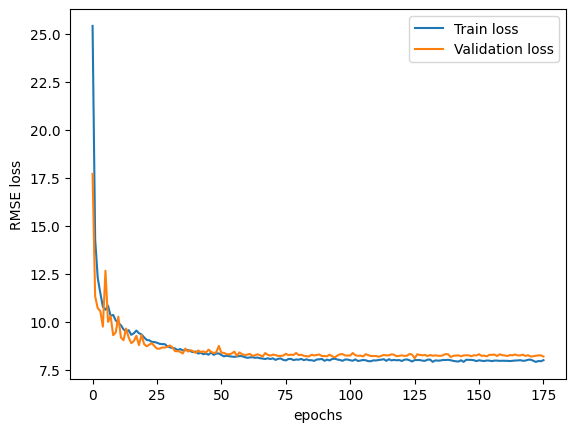

In [597]:
plt.plot(losses, label="Train loss")
plt.plot(valids, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("RMSE loss")
plt.legend(loc="upper right")

In [598]:
model = DemandPrediction(seq_len=SEQ_LEN).cuda()
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [611]:
avg_loss = 0
model.eval()
with torch.no_grad():
    for batch_idx, samples in enumerate(test_loader):
        optimizer.zero_grad()
        x, y_true, spatio_embedding, temporal_embedding = samples
        y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
        loss = criterion(y_pred, y_true.float().cuda())
        avg_loss += loss.item()

print(f"Test RMSE: {np.sqrt(avg_loss / len(test_loader)):.6f}")

Test RMSE: 7.510593


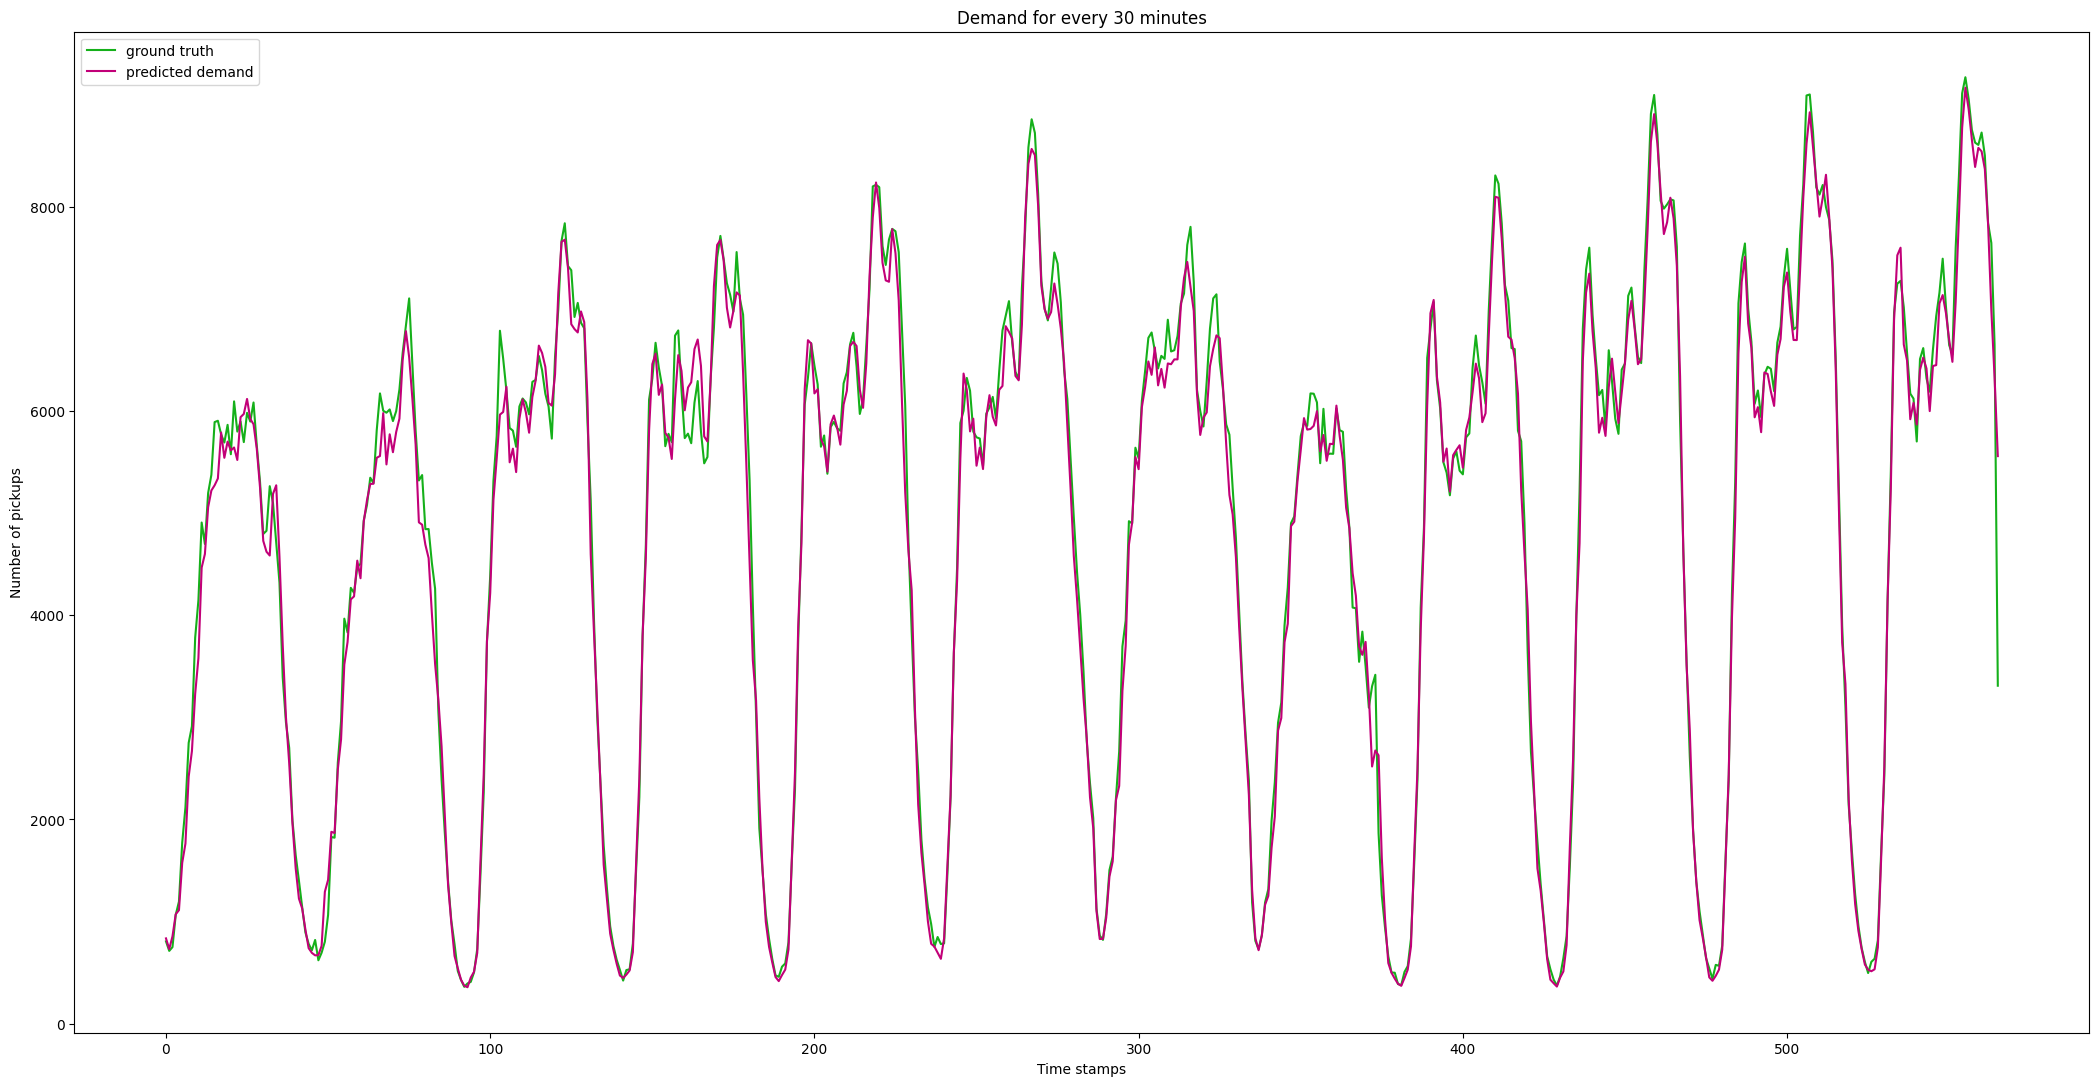

In [600]:
ground_truth = []
predicted_demand = []
model.eval()
with torch.no_grad():
    for batch_idx, samples in enumerate(test_loader):
        optimizer.zero_grad()
        x, y_true, spatio_embedding, temporal_embedding = samples
        y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
        predicted_demand.append(y_pred.cpu().sum())
        ground_truth.append(y_true.sum())

plt.figure(figsize=(26,13))

timestamps = [s for s in range(0,len(test_loader))]
plt.plot(timestamps,ground_truth,'xkcd:green',label = 'ground truth')
plt.plot(timestamps,predicted_demand,'xkcd:magenta',label = 'predicted demand')

plt.xlabel('Time stamps')
plt.ylabel('Number of pickups')
plt.title('Demand for every 30 minutes')
plt.legend()
plt.show()

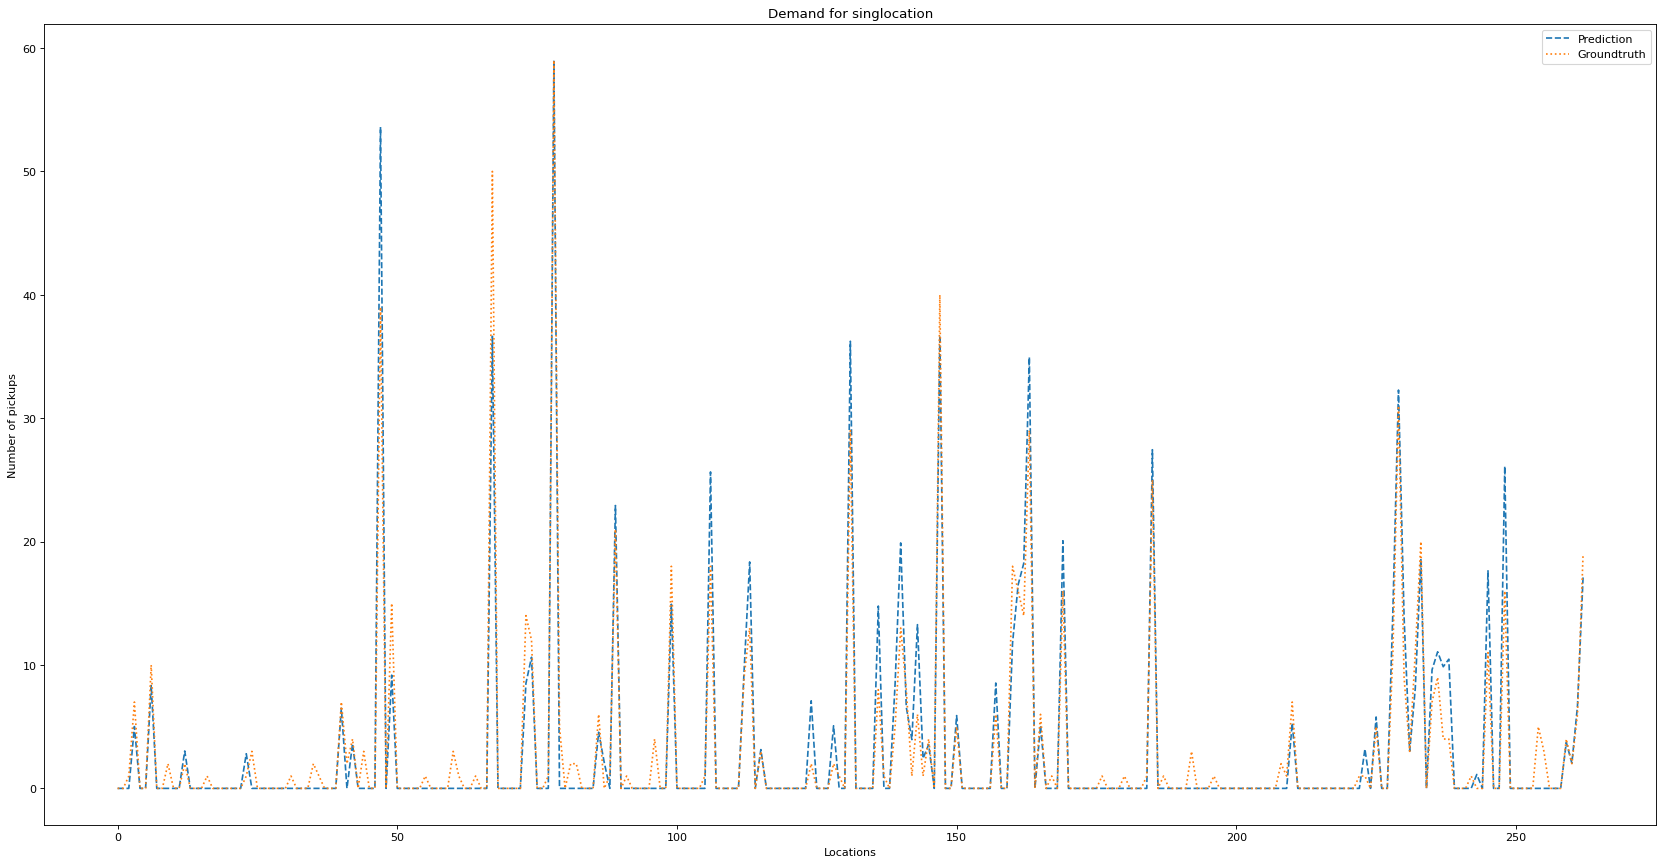

In [601]:
from matplotlib.pyplot import figure

figure(figsize=(26, 13), dpi=80)

model.eval()
with torch.no_grad():
    for batch_idx, samples in enumerate(test_loader):
        x, y_true, spatio_embedding, temporal_embedding = samples
        y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
        plt.plot(y_pred[0].cpu().detach().numpy(), '--', label = 'Prediction')
        plt.plot(y_true[0], ':', label = 'Groundtruth')

        plt.xlabel('Locations')
        plt.ylabel('Number of pickups')
        plt.title('Demand for singlocation')
        plt.legend()
        break